
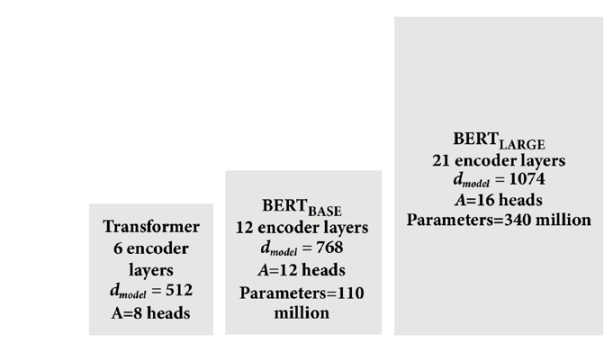

The authors of BERT came up with bidirectional attention, letting an attention head attend to all
of the words both from left to right and right to left. In other words, the self-attention mask of an
encoder could do the job without being hindered by the masked multi-head attention sub-layer
of the decoder.
The model was trained with two tasks. The first method is Masked Language Modeling (MLM).
The second method is Next Sentence Prediction (NSP)

### Tokenization 

In [1]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text = "BERT preprocessing is essential."
tokens = tokenizer.tokenize(text)

print(tokens)

['bert', 'prep', '##ro', '##ces', '##sing', 'is', 'essential', '.']


### Sequence Classification 

In [2]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

text = "This movie not was amazing!"
inputs = tokenizer(text, return_tensors='pt')
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=1)
print(predictions)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0])


### Advanced Fine-tuning 

In [3]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

text = "Advanced fine-tuning with BERT."
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
outputs = model(**inputs, output_hidden_states=True)

intermediate_layer = outputs.hidden_states[6]  # 7th layer
print(intermediate_layer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[[-0.3527, -1.1815, -0.3027,  ..., -0.1794,  0.0872,  0.5573],
         [-0.3768,  0.1754,  0.3395,  ..., -0.0359,  0.2162, -1.2251],
         [ 1.8406, -0.6458,  0.5841,  ..., -0.7345,  0.7542, -0.1614],
         ...,
         [ 1.0414, -0.7009,  1.0362,  ...,  1.0581, -0.3068, -1.4171],
         [-0.8934, -0.8139, -0.3154,  ..., -0.3933, -0.6383,  0.0522],
         [ 0.0143, -0.0423, -0.0131,  ...,  0.0044, -0.0140, -0.0394]]],
       grad_fn=<NativeLayerNormBackward0>)


In [ ]:
## BERT FINE TUNING SOULUTION

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

In [5]:
from tqdm import tqdm, trange

In [6]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Loading the dataset

In [8]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape   

(8551, 4)

In [9]:
df.sample(10)

,sentence_source,label,label_notes,sentence
5893,c_13,1,NaN,this key will open the door to the linguistics...
5404,b_73,0,*,i 've kicked more of a man than you have .
1802,r-67,0,*,the socks are ready for you to announce that y...
2231,l-93,1,NaN,"this lotion softens , soothes , and protects ."
4226,ks08,1,NaN,few approve of our remedy .
2130,rhl07,1,NaN,i think it 's time you give your lovely illnes...
4459,ks08,1,NaN,john did leave .
8256,ad03,1,NaN,i thought of the moon
927,bc01,1,NaN,"while truman did n't visit me , he did you ."
3681,ks08,1,NaN,john suddenly put off the customers .


### Creating sentences, label lists, and adding BERT tokens

In [10]:
#sentences = df.sentence.values
# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
#sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
#print(sentences[1])
#labels = df.label.values
#print('Labels', labels)

# Prepare sentences and labels
sentences = df['sentence'].values
labels = df['label'].values


# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  our friends wo n't buy this analysis , let alone the next one we propose .
Tokenized:  ['our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 24185, 1050, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


### Activating the BERT tokenizer

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenized_texts = [tokenizer.tokenize(text) for text in sentences]
#print ("Tokenize the first sentence:")
#print (tokenized_texts[0])

encoded_data = tokenizer.batch_encode_plus(
    sentences,
    add_special_tokens=True,
    max_length=128,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
print("First input ID:")
print(input_ids[0])
print("First attention mask:")
print(attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\amber\anaconda3\envs\transformer\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


First input ID:
tensor([  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,  4106,
         1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0

### Splitting the data into training and validation sets

In [17]:
# Use train_test_split to split our data into train and validation sets for training
batch_size = 32

# Convert labels to tensors
if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)
else:
    labels = labels.clone().detach()

# Move inputs and labels to the GPU
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)


data = TensorDataset(input_ids, attention_masks, labels)

train_data, val_data  = train_test_split(data, test_size=0.1, random_state=42)

train_dataloader = DataLoader(train_data,
                             sampler=RandomSampler(train_data),
                             batch_size=batch_size)
val_dataloader = DataLoader(val_data,
                           sampler = SequentialSampler(val_data),
                           batch_size=batch_size)

### BERT model configuration

In [25]:

import transformers
from transformers import BertModel, BertConfig

# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Define optimizer and scheduler using PyTorch's AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 15
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\amber\anaconda3\envs\transformer\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### The training loop

In [29]:
# Training function with tqdm
def train():
    model.train()
    total_loss = 0.0
    correct = 0
    num_batches = len(train_dataloader)
    with tqdm(total = len(train_dataloader), desc = "Training") as pbar:
        for batch in train_dataloader:            
            #inputs, attention_mask, labels = batch            
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

            batch = tuple(t.to(device) for t in batch)
            #inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
                       
            optimizer.zero_grad(set_to_none=True)
            #outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            predicted = outputs.logits.argmax(dim=1)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            correct += (predicted == labels).type(torch.float).sum().item()
            pbar.update(1)
    avg_train_loss = total_loss/num_batches
    train_acc = correct/len(train_dataloader.dataset)
    return avg_train_loss,train_acc

# Evaluation function with tqdm
def evaluate():
    model.eval()
    eval_loss = 0.0
    correct = 0
    preds = []
    with tqdm(total = len(val_dataloader), desc="Evaluating") as pbar:
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            num_batches = len(va) 
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            with torch.no_grad():
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits
            eval_loss += loss.item()
            predicted = logits.argmax(dim=1)
            correct += (predicted == labels).type(torch.float).sum().item()
            preds.append(logits)
            pbar.update(1)

    avg_val_loss = eval_loss / num_batches
    val_acc  = correct / len(val_dataloader.dataset)
    preds = torch.cat(preds, dim=0)
    return avg_val_loss, preds
  

In [30]:
epochs = 5  # Set a high number of epochs

# Assign the initial loss to infinite
best_valid_loss = float('inf')
patience = 5
patience_counter = 0


In [ ]:

# Create an empty list to store training and validation loss of each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# For each epoch
for epoch in tqdm(range(epochs), desc="Epoch"):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    train_loss, train_acc = train()
    valid_loss, val_acc, preds = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(val_acc)
    print(f'\nTraining Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}, Validation Accuracy: {val_acc:.3f}')
    
    if patience_counter >= patience:
        print("Early stopping due to no improvement in validation loss.")
        break

print("\nTraining complete!")

In [ ]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Get the model predictions on the validation data
valid_loss, val_acc, preds = evaluate()
print(valid_loss)

# Classification report
y_pred = np.argmax(preds.cpu().numpy(), axis=1)
print(classification_report(labels, y_pred))

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(15, 8))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Validation")
plt.legend()
plt.show()

In [ ]:
# Plot the training and validation accuracy
plt.figure(figsize=(15, 8))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Train")
plt.plot(valid_accuracies, label="Validation")
plt.legend()
plt.show()